In [1]:
import os
import json
import pandas as pd
import numpy as np
%pip install xgboost
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
%pip install requests
import requests

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 4.2 MB/s eta 0:00:17
   - -------------------------------------- 1.8/72.0 MB 4.6 MB/s eta 0:00:16
   - -------------------------------------- 2.6/72.0 MB 4.6 MB/s eta 0:00:16
   - -------------------------------------- 3.4/72.0 MB 4.3 MB/s eta 0:00:17
   -- ------------------------------------- 4.2/72.0 MB 3.9 MB/s eta 0:00:18
   -- ------------------------------------- 5.0/72.0 MB 3.9 MB/s eta 0:00:18
   --- ------------------------------------ 7.1/72.0 MB 4.9 MB/s eta 0:00:14
   ----- ---------------------------------- 10.7/72.0 MB 6.4 MB/s eta 0:00:10
   ------- -------------------------------- 13.9/72.0 MB 7.4 MB/s eta 0:00:08
   --------- ------------------------------ 16.5/72.0 MB 7.9 MB/s eta 0:00:07
   ----------- ---------------------------- 19.9/72.0 MB 8.8 MB/s eta 0:00:06
   ------------- -------------------------- 25.2/72.0 MB 10.1 MB/s eta 0:00:05



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests

# --- FETCH ITEM DATA ---
try:
    versions = requests.get("https://ddragon.leagueoflegends.com/api/versions.json").json()
    latest_version = versions[0]
    # Fetch the full item database
    item_json = requests.get(f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/item.json").json()
    
    # 1. Create Name Lookup
    item_lookup = {int(k): v['name'] for k, v in item_json['data'].items()}
    
    # 2. Identify "Legendary" Items (Depth >= 3 or High Cost)
    # We filter out boots and components using 'depth' and 'gold'
    VALID_LEGENDARY_IDS = set()
    
    for k, v in item_json['data'].items():
        item_id = int(k)
        # 'depth' usually tracks build hierarchy (1=Basic, 2=Component, 3=Completed)
        depth = v.get('depth', 1)
        gold_total = v['gold']['total']
        
        # RULE: Keep if Depth is 3+ OR it costs > 2000g (covers some weird edge cases)
        # This removes Doran's (Depth 1), Components (Depth 2), and Boots (Depth 2)
        if depth >= 3 or gold_total > 2000:
            VALID_LEGENDARY_IDS.add(item_id)
            
    print(f"Patch {latest_version}: Identified {len(VALID_LEGENDARY_IDS)} Legendary/Mythic items.")

except Exception as e:
    print(f"Error fetching Item Data: {e}")
    item_lookup = {}
    VALID_LEGENDARY_IDS = set()

def get_item_name(item_id):
    return item_lookup.get(item_id, f"Item {item_id}")

# --- CONFIG ---
DATA_PATH = os.path.join('Data', 'parsed_matches_irons')
CHAMP_META_PATH = 'champ_data.csv'

Patch 16.1.1: Identified 332 Legendary/Mythic items.


In [3]:
# DATA_PATH = os.path.join('Data', 'parsed_matches_irons')
TOP_N_ITEMS = 50 

# Items to completely ignore (Consumables, Wards, etc.)
IGNORE_IDS = {
    2003, 2031, 2055, 3340, 3364, 3363, # Potions, Wards
    2010, 2020, 2420, 2421, 2423, # Biscuits, Stopwatch components
}

def get_clean_purchase_order(purchase_list):
    """
    Returns a chronologically sorted list of item IDs, filtering out noise.
    """
    # 1. Sort by timestamp
    sorted_events = sorted(purchase_list, key=lambda x: x['timestamp'])
    
    # 2. Extract IDs (Purchase Only)
    # Note: We ignore 'Sell' events for simplicity in this sequential model 
    # (Assuming we only predict the "Build Up" phase)
    raw_order = [x['itemId'] for x in sorted_events if x['type'] == 'ITEM_PURCHASED']
    
    # 3. Remove Junk
    clean_order = [i for i in raw_order if i not in IGNORE_IDS]
    
    return clean_order

In [4]:
# Load Champion Metadata
champ_meta = pd.read_csv(CHAMP_META_PATH)
champ_dict = champ_meta.set_index('Champion').to_dict('index')

# --- CONFIG: LIST OF DATA FOLDERS ---
DATA_FOLDERS = [
    os.path.join( 'parsed_matches'),

]

# --- HELPER FUNCTIONS ---
def calculate_gold_velocity(player_data, purchase_timestamp_ms):
    """Returns the Gold Gained in the 5 minutes AFTER the purchase."""
    gold_curve = player_data.get('gold_curve', [])
    if not gold_curve: return 0
    
    purchase_minute = int(purchase_timestamp_ms / 60000)
    future_minute = purchase_minute + 5
    
    if purchase_minute >= len(gold_curve): return 0
    
    current_gold = gold_curve[purchase_minute]
    future_index = min(future_minute, len(gold_curve) - 1)
    future_gold = gold_curve[future_index]
    
    return future_gold - current_gold

def get_legendary_sequence(purchase_list):
    """Returns only LEGENDARY item purchases in order."""
    sorted_events = sorted(purchase_list, key=lambda x: x['timestamp'])
    events = []
    for x in sorted_events:
        if x['type'] == 'ITEM_PURCHASED' and x['itemId'] in VALID_LEGENDARY_IDS:
            events.append((x['itemId'], x['timestamp']))
    return events

# --- MAIN LOADING LOOP ---
training_rows = []
raw_matches = []

print(f"Scanning data folders...")

# Loop through BOTH folders
for folder_path in DATA_FOLDERS:
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue
        
    print(f"Loading from: {folder_path}")
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'): continue
        try:
            with open(os.path.join(folder_path, filename), 'r') as f:
                raw_matches.append(json.load(f))
        except: continue

print(f"Total Matches Loaded: {len(raw_matches)}")

# Process Matches
for match_data in raw_matches:
    participants = match_data['participants']
    lane_map = {(p['teamId'], p['lane']): p for p in participants}
    
    for p in participants:
        if p['championName'] not in champ_dict: continue
        
        enemy_team = 200 if p['teamId'] == 100 else 100
        opponent = lane_map.get((enemy_team, p['lane']))
        
        if not opponent or opponent['championName'] not in champ_dict: continue
        
        # Get Legendary Only Sequence
        legendary_seq = get_legendary_sequence(p['item_purchases'])
        
        if len(legendary_seq) < 1: continue 
        
        current_inventory = []
        
        for item_id, timestamp in legendary_seq:
            gold_score = calculate_gold_velocity(p, timestamp)
            
            training_rows.append({
                'my_class': champ_dict[p['championName']].get('Class', 'Unknown'),
                'my_dmg': champ_dict[p['championName']].get('DmgType', 'Mixed'),
                'my_lane': p['lane'],
                'enemy_class': champ_dict[opponent['championName']].get('Class', 'Unknown'),
                'enemy_dmg': champ_dict[opponent['championName']].get('DmgType', 'Mixed'),
                'current_inventory': list(current_inventory),
                'target_item': item_id,
                'gold_gain_5min': gold_score
            })
            current_inventory.append(item_id)

df = pd.DataFrame(training_rows)

# --- NEW: FILTER OUT "BAD" BUILDS ---
print(f"Original Row Count: {len(df)}")

# 1. Calculate the baseline (Passive gold is ~600g in 5 mins. If you have less, you were likely dead/AFK)
# We can also drop the bottom 25% of "performance" to weed out bad games.
threshold = df['gold_gain_5min'].quantile(0.25) 
print(f"Dropping decisions where Gold Gain < {threshold:.0f}g")

# 2. Keep only the "Successful" decisions
df_clean = df[df['gold_gain_5min'] > threshold].copy()

print(f"Cleaned Row Count: {len(df_clean)}")

# Replace the training dataframe with the clean one
df = df_clean

seen_items = set(df['target_item'].unique())
print(f"Training on {len(seen_items)} unique Legendary items.")
print(f"Generated {len(df)} training examples.")
df.head()

Scanning data folders...
Loading from: parsed_matches
Total Matches Loaded: 6084
Original Row Count: 178882
Dropping decisions where Gold Gain < 1519g
Cleaned Row Count: 134155
Training on 105 unique Legendary items.
Generated 134155 training examples.


,my_class,my_dmg,my_lane,enemy_class,enemy_dmg,current_inventory,target_item,gold_gain_5min
0,Fighter,AD,TOP,Fighter,AD,[],3078,1709
2,Fighter,AD,TOP,Fighter,AD,"[3078, 6694]",3053,2495
4,Fighter,AD,JUNGLE,Fighter,AD,[],3078,1563
5,Fighter,AD,JUNGLE,Fighter,AD,[3078],6610,1693
6,Fighter,AD,JUNGLE,Fighter,AD,"[3078, 6610]",3174,3289


In [6]:
# A. Encode Target (The Item ID to predict)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['target_item'])

print(f"Target classes: {len(label_encoder.classes_)}")
# Added to the end of Cell 96
top_items_counts = df['target_item'].value_counts().head(TOP_N_ITEMS)
top_items_set = set(top_items_counts.index)

# B. Encode "Current Inventory" (Multi-Hot)
# We use MultiLabelBinarizer to turn the list [A, B] into columns [Item_A=1, Item_B=1, Item_C=0...]
# IMPORTANT: We only use the Top 50 items as features too
mlb = MultiLabelBinarizer(classes=sorted(list(top_items_set)))
X_inventory = mlb.fit_transform(df['current_inventory'])
inventory_cols = [f"inv_{i}" for i in mlb.classes_]
X_inventory_df = pd.DataFrame(X_inventory, columns=inventory_cols)

# C. Encode Matchup Stats (One-Hot)
cat_features = ['my_class', 'my_dmg', 'my_lane', 'enemy_class', 'enemy_dmg']
X_context = pd.get_dummies(df[cat_features])

# D. Combine All Features
X = pd.concat([X_context.reset_index(drop=True), X_inventory_df.reset_index(drop=True)], axis=1)

print(f"Final Feature Count: {X.shape[1]}")

Target classes: 105
Final Feature Count: 73


c:\Users\Laurent\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:1007: UserWarning: unknown class(es) [2065, 2501, 2502, 2504, 3002, 3004, 3026, 3050, 3053, 3065, 3068, 3073, 3074, 3083, 3084, 3085, 3087, 3091, 3102, 3109, 3110, 3119, 3135, 3137, 3139, 3143, 3156, 3165, 3176, 3179, 3181, 3190, 3222, 3302, 3504, 3748, 4005, 4401, 4629, 4643, 6609, 6616, 6617, 6620, 6621, 6662, 6664, 6665, 6675, 6695, 6697, 6699, 6701, 8010, 8020] will be ignored
  warnings.warn(


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Configuration
# objective='multi:softprob' allows us to get probabilities for Top-K calculation
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob', 
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    random_state=42
)

print("Training XGBoost...")
model.fit(X_train, y_train)
print("Training Complete.")

Training XGBoost...
Training Complete.


In [8]:
# Get probabilities for test set
probs = model.predict_proba(X_test)

# Function to check if the true label is in the top K predictions
def get_top_k_accuracy(y_true, y_probs, k=3):
    top_k_preds = np.argsort(y_probs, axis=1)[:, -k:] # Indices of top k
    hits = 0
    for i, true_label in enumerate(y_true):
        if true_label in top_k_preds[i]:
            hits += 1
    return hits / len(y_true)

acc_1 = accuracy_score(y_test, model.predict(X_test))
acc_3 = get_top_k_accuracy(y_test, probs, k=3)

print(f"Strict Accuracy (Top-1): {acc_1:.2%}")
print(f"Helper Accuracy (Top-3): {acc_3:.2%}")

Strict Accuracy (Top-1): 32.40%
Helper Accuracy (Top-3): 60.74%


In [11]:
def get_recommendation(my_class, my_dmg, my_lane, en_class, en_dmg, current_items):
    # 1. Build Input Vector
    input_vector = pd.DataFrame(0, index=[0], columns=X.columns)
    
    # Set Category Flags
    cats = {
        f"my_class_{my_class}": 1, f"my_dmg_{my_dmg}": 1, f"my_lane_{my_lane}": 1,
        f"enemy_class_{en_class}": 1, f"enemy_dmg_{en_dmg}": 1
    }
    for col, val in cats.items():
        if col in input_vector.columns: input_vector[col] = val
            
    # Set Inventory Flags
    for item_id in current_items:
        col = f"inv_{item_id}"
        if col in input_vector.columns: input_vector[col] = 1
            
    # 2. Predict
    pred_probs = model.predict_proba(input_vector)[0]
    
    # 3. Decode & Print with Names
    top_3_idx = np.argsort(pred_probs)[-3:][::-1]
    
    print(f"--- Situation: {my_class} vs {en_class} ---")
    print(f"Owned: {[get_item_name(i) for i in current_items]}")
    print("Recommended Next Items:")
    
    for idx in top_3_idx:
        item_id = label_encoder.inverse_transform([idx])[0]
        name = get_item_name(item_id) # <--- USING THE TRANSLATOR HERE
        prob = pred_probs[idx]
        print(f"  {name} ({item_id}): {prob:.1%}")

# Test Scenario: 
# Fighter vs Tank. I already have Boots (1001) and Trinity Force (3078). What's next?
# (Note: Replace IDs with ones that actually exist in your Top 50 list)
test_inv = [list(top_items_set)[0], list(top_items_set)[1]] 
get_recommendation('Fighter', 'AD', 'TOP', 'Tank', 'Mixed', test_inv)

--- Situation: Fighter vs Tank ---
Owned: ['Bloodthirster', 'Rod of Ages']
Recommended Next Items:
  Trinity Force (3078): 12.8%
  Stridebreaker (6631): 10.3%
  Eclipse (6692): 9.3%


C:\Users\Laurent\AppData\Local\Temp\ipykernel_8980\1815472571.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


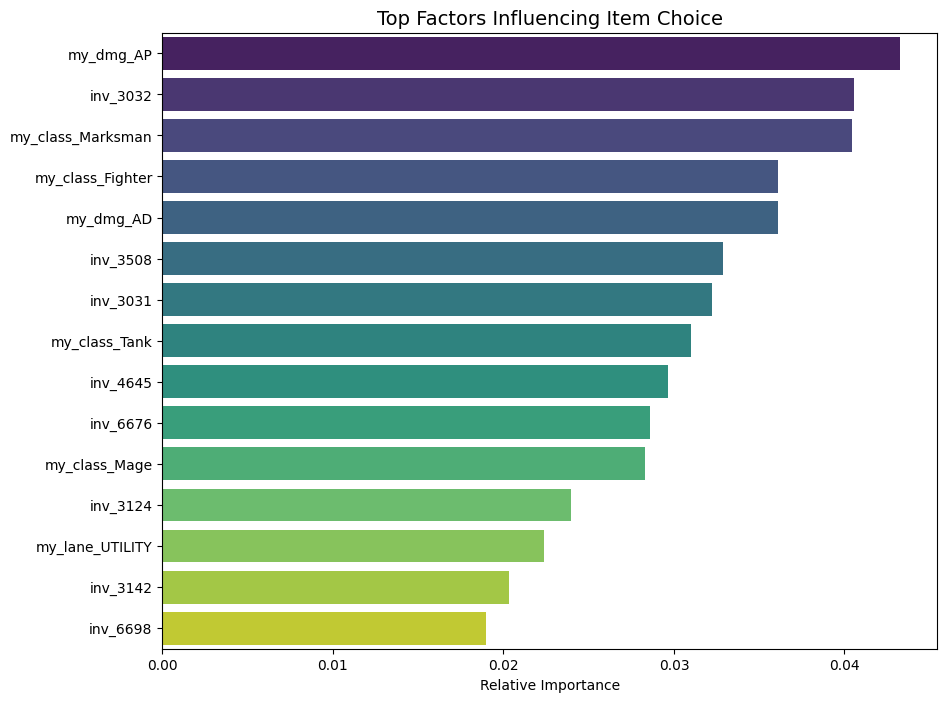

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# Get Top 15 features
importance = model.feature_importances_
feature_names = X.columns
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Top Factors Influencing Item Choice', fontsize=14)
plt.xlabel('Relative Importance')
plt.ylabel('')
plt.show()

--- STANDARD METRICS ---
Top-1 Accuracy: 32.4%
Top-3 Accuracy: 60.7% (Industry Standard for Recommenders)
Top-5 Accuracy: 74.4%
------------------------------


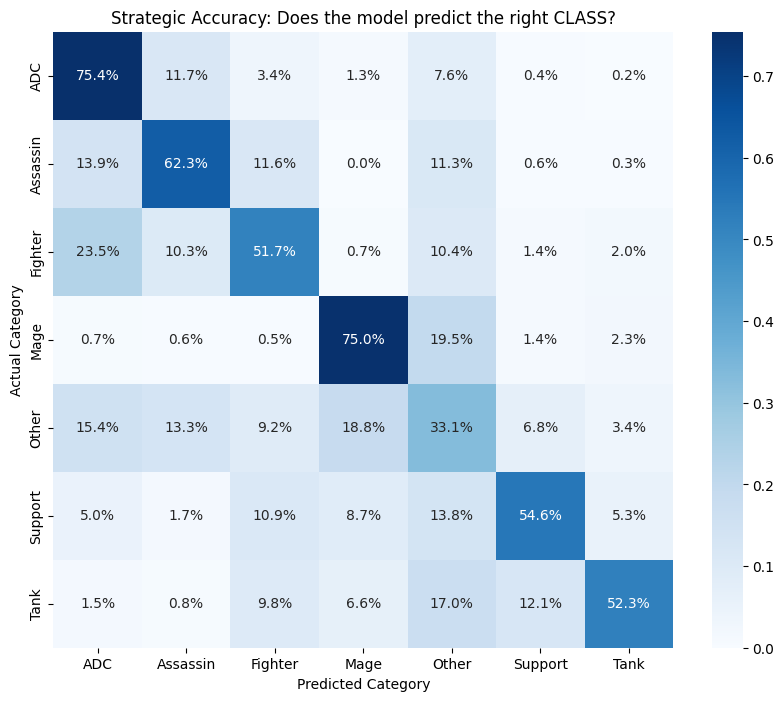


--- PREDICTION GALLERY (5 RANDOM EXAMPLES) ---

Scenario: Marksman vs Marksman
Inventory: ['Infinity Edge', 'The Collector']
True Next Item: The Collector
Model Recommends:
  - Lord Dominik's Regards: 31.2%
  - Rapid Firecannon: 20.5%
  - Gunmetal Greaves: 11.0%

Scenario: Fighter vs Fighter
Inventory: ["Youmuu's Ghostblade"]
True Next Item: Crimson Lucidity
Model Recommends:
  - Opportunity: 29.4%
  - Edge of Night: 13.3%
  - Serylda's Grudge: 13.2%

Scenario: Support vs Marksman
Inventory: Empty
True Next Item: Echoes of Helia
Model Recommends:
  - Redemption: 13.8%
  - Moonstone Renewer: 12.0%
  - Imperial Mandate: 9.5%

Scenario: Fighter vs Mage
Inventory: Empty
True Next Item: Blade of The Ruined King
Model Recommends:
  - Blade of The Ruined King: 47.0%
  - Eclipse: 8.4%
  - Kraken Slayer: 6.6%

Scenario: Support vs Mage
Inventory: Empty
True Next Item: Black Cleaver
Model Recommends:
  - Redemption: 14.2%
  - Moonstone Renewer: 12.2%
  - Imperial Mandate: 9.7%


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. DEFINE ITEM ARCHETYPES ---

item_archetypes = {
    # --- FIGHTER (Bruiser / AD + Health) ---
    3078: 'Fighter', # Trinity Force
    6630: 'Fighter', # Goredrinker (Legacy/Mode specific)
    6631: 'Fighter', # Stridebreaker
    3071: 'Fighter', # Black Cleaver
    6632: 'Fighter', # Divine Sunderer (Legacy) / Sunderer items
    3053: 'Fighter', # Sterak's Gage
    6333: 'Fighter', # Death's Dance
    3074: 'Fighter', # Ravenous Hydra
    3748: 'Fighter', # Titanic Hydra
    3161: 'Fighter', # Spear of Shojin
    6692: 'Fighter', # Eclipse (Often built by fighters too)
    5565: 'Fighter', # Sundered Sky
    3072: 'Fighter', # Bloodthirster (Often ADC, but high AD)
    3153: 'Fighter', # Blade of the Ruined King (Hybrid)

    # --- TANK (Resistances / HP) ---
    3068: 'Tank', # Sunfire Aegis
    3065: 'Tank', # Spirit Visage
    3075: 'Tank', # Thornmail
    3001: 'Tank', # Abyssal Mask
    3111: 'Tank', # Mercury's Treads (If included) / Chains
    3047: 'Tank', # Plated Steelcaps (If included)
    3110: 'Tank', # Frozen Heart
    3025: 'Tank', # Iceborn Gauntlet
    3083: 'Tank', # Warmog's Armor
    3084: 'Tank', # Heartsteel
    6665: 'Tank', # Jak'Sho
    6667: 'Tank', # Radiant Virtue
    5587: 'Tank', # Kaenic Rookern
    4401: 'Tank', # Force of Nature
    8001: 'Tank', # Anathema's Chains
    2502: 'Tank', # Unending Despair
    2504: 'Tank', # Hollow Radiance

    # --- MAGE (AP / Magic Pen) ---
    6653: 'Mage', # Liandry's
    6655: 'Mage', # Luden's
    3089: 'Mage', # Rabadon's Deathcap
    4645: 'Mage', # Shadowflame
    3157: 'Mage', # Zhonya's Hourglass
    3100: 'Mage', # Lich Bane
    3102: 'Mage', # Banshee's Veil
    3165: 'Mage', # Morellonomicon
    3116: 'Mage', # Rylai's Crystal Scepter
    3135: 'Mage', # Void Staff
    4646: 'Mage', # Stormsurge
    3118: 'Mage', # Malignance
    3003: 'Mage', # Archangel's Staff / Seraph's
    3027: 'Mage', # Rod of Ages
    3115: 'Mage', # Nashor's Tooth
    3152: 'Mage', # Hextech Rocketbelt

    # --- ADC (Crit / Attack Speed) ---
    6671: 'ADC', # Galeforce (Legacy) / Wind items
    3031: 'ADC', # Infinity Edge
    3036: 'ADC', # Lord Dominik's Regards
    3046: 'ADC', # Phantom Dancer
    3094: 'ADC', # Rapid Firecannon
    3095: 'ADC', # Stormrazor
    6672: 'ADC', # Kraken Slayer
    3087: 'ADC', # Statikk Shiv
    3033: 'ADC', # Mortal Reminder
    6673: 'ADC', # Immortal Shieldbow
    3124: 'ADC', # Guinsoo's Rageblade
    3091: 'ADC', # Wit's End (Hybrid)
    3139: 'ADC', # Mercurial Scimitar

    # --- ASSASSIN (Lethality) ---
    3142: 'Assassin', # Youmuu's Ghostblade
    6691: 'Assassin', # Duskblade (Legacy) / Lethality Mythics
    3179: 'Assassin', # Umbral Glaive
    3814: 'Assassin', # Edge of Night
    3134: 'Assassin', # Hubris
    6696: 'Assassin', # Axiom Arc
    6695: 'Assassin', # Serpent's Fang
    6698: 'Assassin', # Profane Hydra / Opportunity
    3156: 'Assassin', # Maw of Malmortius (Hybrid Defense)
    6676: 'Assassin', # The Collector (Crit/Lethality hybrid)

    # --- SUPPORT (Utility) ---
    3190: 'Support', # Locket of the Iron Solari
    3174: 'Support', # Imperial Mandate
    6617: 'Support', # Moonstone Renewer
    2065: 'Support', # Shurelya's Battlesong
    3504: 'Support', # Ardent Censer
    3107: 'Support', # Redemption
    3222: 'Support', # Mikael's Blessing
    3119: 'Support', # Echoes of Helia
}

def get_archetype(item_id):
    # This 'Other' is now the real enemy. We want this to be empty.
    return item_archetypes.get(item_id, 'Other')


# --- 2. CALCULATE METRICS ---
y_pred_probs = model.predict_proba(X_test)
y_pred_ids = model.predict(X_test)

# Top-N Accuracy
def get_top_n_acc(n=3):
    top_n_idx = np.argsort(y_pred_probs, axis=1)[:, -n:]
    hits = 0
    for i, true_val in enumerate(y_test):
        if true_val in top_n_idx[i]:
            hits += 1
    return hits / len(y_test)

acc_1 = accuracy_score(y_test, y_pred_ids)
acc_3 = get_top_n_acc(3)
acc_5 = get_top_n_acc(5)

print(f"--- STANDARD METRICS ---")
print(f"Top-1 Accuracy: {acc_1:.1%}")
print(f"Top-3 Accuracy: {acc_3:.1%} (Industry Standard for Recommenders)")
print(f"Top-5 Accuracy: {acc_5:.1%}")
print("-" * 30)

# --- 3. PLOT ARCHETYPE CONFUSION MATRIX ---
# This shows if the model confuses "Tanks" with "Mages" (Bad) or "Tanks" with "Tanks" (Good)

# Convert IDs to Names (Tank, Mage, etc.)
true_cats = [get_archetype(label_encoder.inverse_transform([y])[0]) for y in y_test]
pred_cats = [get_archetype(label_encoder.inverse_transform([y])[0]) for y in y_pred_ids]

labels = sorted(list(set(item_archetypes.values()) | {'Other'}))
cm = confusion_matrix(true_cats, pred_cats, labels=labels, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Strategic Accuracy: Does the model predict the right CLASS?')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()

# --- 4. GENERATE A "GALLERY" OF PREDICTIONS ---
# Show 5 random examples to prove breadth
print("\n--- PREDICTION GALLERY (5 RANDOM EXAMPLES) ---")

sample_indices = np.random.choice(X_test.index, 5, replace=False)

for idx in sample_indices:
    row = X_test.loc[[idx]] # Keep as DataFrame
    
    # Reconstruct readable context from One-Hot columns
    # (This assumes standard naming like 'my_class_Fighter')
    my_role = [c.split('_')[-1] for c in row.columns if 'my_class' in c and row[c].values[0] == 1]
    my_role = my_role[0] if my_role else "Unknown"
    
    enemy_role = [c.split('_')[-1] for c in row.columns if 'enemy_class' in c and row[c].values[0] == 1]
    enemy_role = enemy_role[0] if enemy_role else "Unknown"
    
    # Get Inventory
    inv_ids = [int(c.split('_')[1]) for c in row.columns if 'inv_' in c and row[c].values[0] == 1]
    inv_names = [get_item_name(i) for i in inv_ids]
    
    # Get Prediction
    pred_prob = model.predict_proba(row)[0]
    top_3 = np.argsort(pred_prob)[-3:][::-1]
    
    print(f"\nScenario: {my_role} vs {enemy_role}")
    print(f"Inventory: {inv_names if inv_names else 'Empty'}")
    print(f"True Next Item: {get_item_name(label_encoder.inverse_transform([y_test[X_test.index.get_loc(idx)]])[0])}")
    print("Model Recommends:")
    for i in top_3:
        item_id = label_encoder.inverse_transform([i])[0]
        name = get_item_name(item_id)
        prob = pred_prob[i]
        print(f"  - {name}: {prob:.1%}")

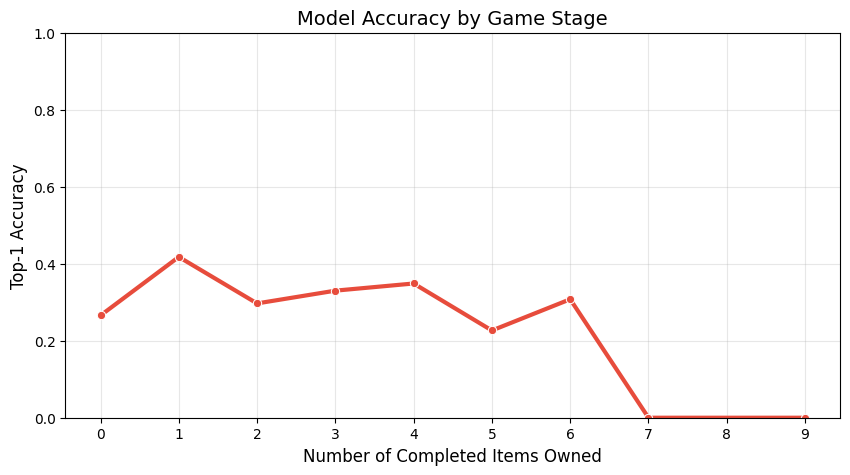

In [14]:
# Create a temporary DataFrame for analysis
analysis_df = X_test.copy()
analysis_df['Correct'] = (y_pred_ids == y_test) # Top-1 Correct
analysis_df['Inventory_Count'] = analysis_df.apply(lambda row: sum(1 for c in row.index if 'inv_' in c and row[c] == 1), axis=1)

# Group by how many items the player has (0 = Start, 1-2 = Early, 3+ = Late)
stage_acc = analysis_df.groupby('Inventory_Count')['Correct'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=stage_acc.index, y=stage_acc.values, marker='o', linewidth=3, color='#e74c3c')
plt.title('Model Accuracy by Game Stage', fontsize=14)
plt.xlabel('Number of Completed Items Owned', fontsize=12)
plt.ylabel('Top-1 Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(int(max(stage_acc.index))+1))
plt.ylim(0, 1) # Scale 0 to 100%
plt.show()

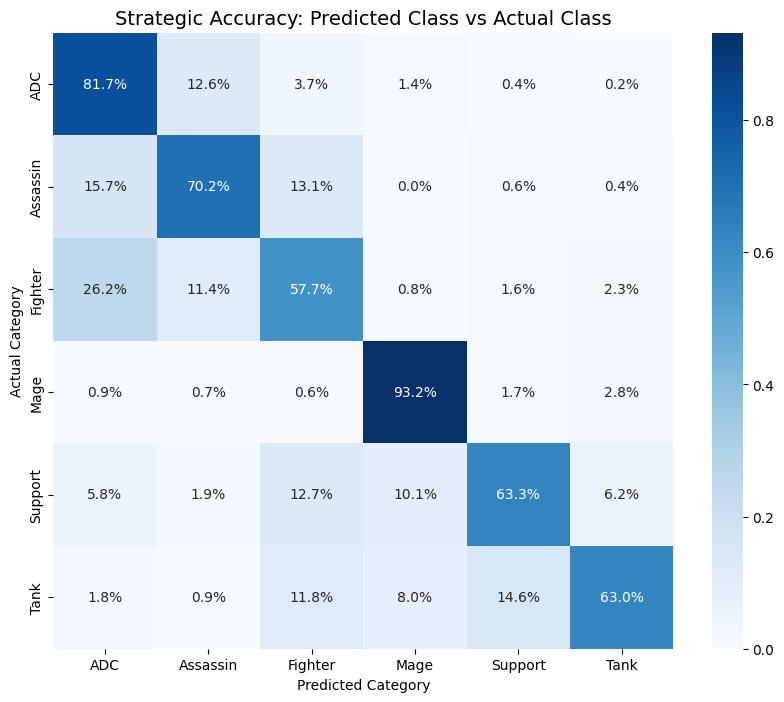

In [15]:
from sklearn.metrics import confusion_matrix

# Use your 'get_archetype' function from the previous step
y_test_cats = [get_archetype(label_encoder.inverse_transform([y])[0]) for y in y_test]
y_pred_cats = [get_archetype(label_encoder.inverse_transform([y])[0]) for y in y_pred_ids]

# Filter out 'Other' to keep the chart clean
labels = sorted(list(set(item_archetypes.values())))
cm = confusion_matrix(y_test_cats, y_pred_cats, labels=labels, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Strategic Accuracy: Predicted Class vs Actual Class', fontsize=14)
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()

C:\Users\Laurent\AppData\Local\Temp\ipykernel_8980\167498766.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lane_acc.index, y=lane_acc.values, palette='magma')


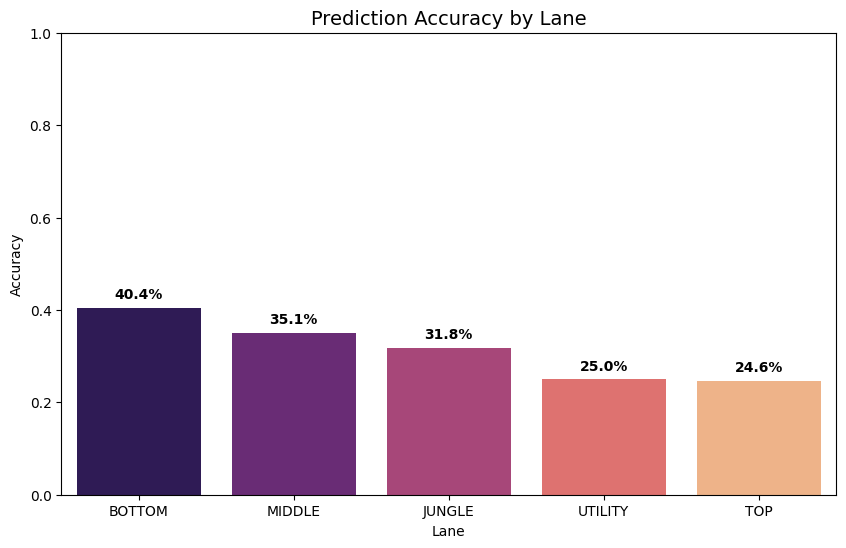

In [16]:
# Extract 'Lane' from the One-Hot columns
# We look for columns starting with 'my_lane_' and value 1
def get_lane(row):
    for col in row.index:
        if 'my_lane_' in col and row[col] == 1:
            return col.replace('my_lane_', '')
    return 'Unknown'

analysis_df['Lane'] = analysis_df.apply(get_lane, axis=1)
lane_acc = analysis_df.groupby('Lane')['Correct'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=lane_acc.index, y=lane_acc.values, palette='magma')
plt.title('Prediction Accuracy by Lane', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
# Add percentage labels on bars
for i, v in enumerate(lane_acc.values):
    plt.text(i, v + 0.02, f"{v:.1%}", ha='center', fontweight='bold')
plt.show()

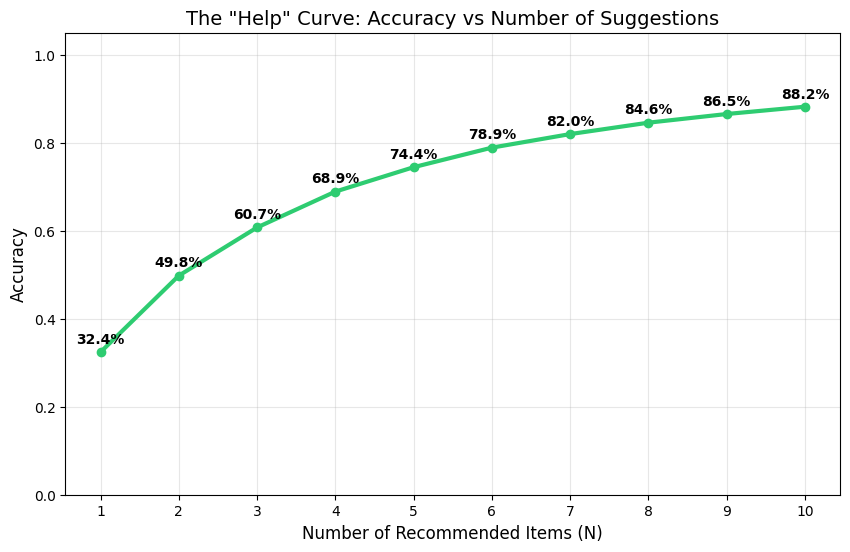

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate Top-K for K=1 to 10
k_values = range(1, 11)
accuracies = []

# Get sorted indices of probabilities (highest prob last)
sorted_indices = np.argsort(y_pred_probs, axis=1)

for k in k_values:
    # Take the last k indices (highest probabilities)
    top_k_indices = sorted_indices[:, -k:]
    
    hits = 0
    for i, true_val in enumerate(y_test):
        if true_val in top_k_indices[i]:
            hits += 1
            
    accuracies.append(hits / len(y_test))

# 2. Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linewidth=3, color='#2ecc71')

# Add labels
for k, acc in zip(k_values, accuracies):
    plt.text(k, acc + 0.02, f"{acc:.1%}", ha='center', fontsize=10, fontweight='bold')

plt.title('The "Help" Curve: Accuracy vs Number of Suggestions', fontsize=14)
plt.xlabel('Number of Recommended Items (N)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.show()

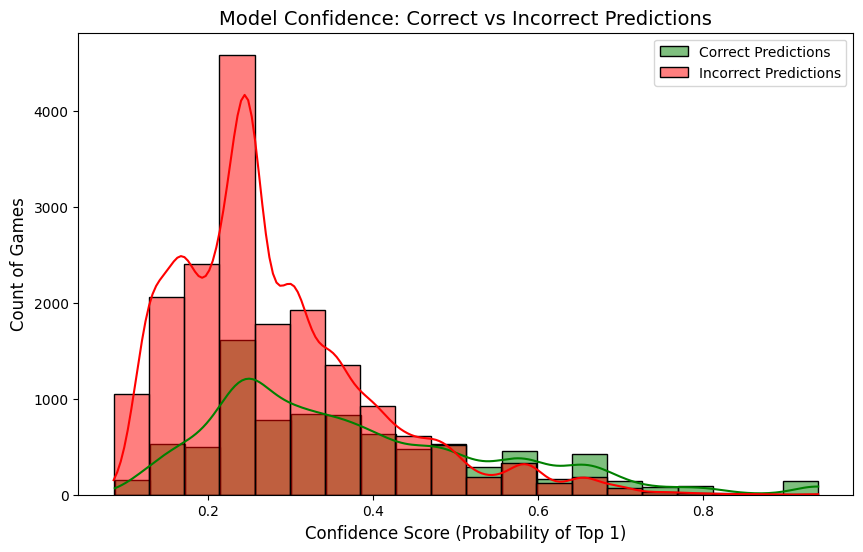

In [18]:
import seaborn as sns

# Create a DataFrame of predictions
pred_df = pd.DataFrame({
    'Max_Prob': np.max(y_pred_probs, axis=1),
    'Is_Correct': (y_pred_ids == y_test)
})

plt.figure(figsize=(10, 6))

# Plot 'Correct' predictions in Green
sns.histplot(data=pred_df[pred_df['Is_Correct']==True], x='Max_Prob', 
             color='green', alpha=0.5, label='Correct Predictions', bins=20, kde=True)

# Plot 'Incorrect' predictions in Red
sns.histplot(data=pred_df[pred_df['Is_Correct']==False], x='Max_Prob', 
             color='red', alpha=0.5, label='Incorrect Predictions', bins=20, kde=True)

plt.title('Model Confidence: Correct vs Incorrect Predictions', fontsize=14)
plt.xlabel('Confidence Score (Probability of Top 1)', fontsize=12)
plt.ylabel('Count of Games', fontsize=12)
plt.legend()
plt.show()

Aligning Data: 26831 test rows vs 134155 dataframe rows.
Found 20076 matching rows for analysis.


C:\Users\Laurent\AppData\Local\Temp\ipykernel_8980\2955388805.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_acc = results_df.groupby('Performance_Tier')['Correct'].mean()
C:\Users\Laurent\AppData\Local\Temp\ipykernel_8980\2955388805.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tier_acc.index, y=tier_acc.values, palette='autumn')


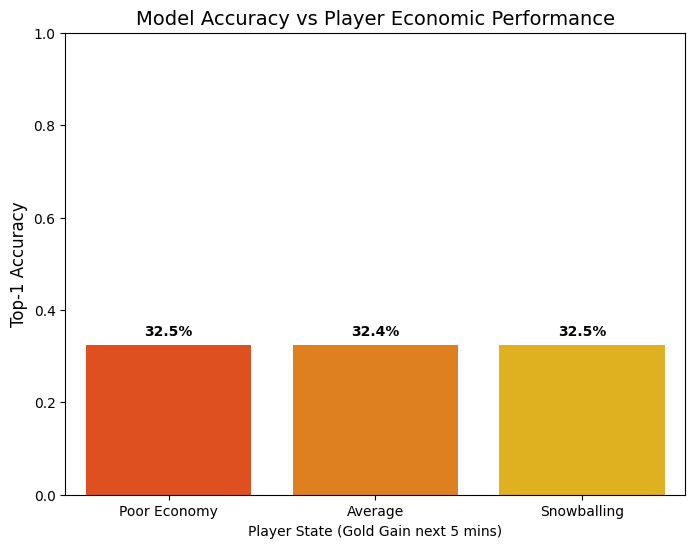

In [ ]:
# 1. Align Test Data with Gold Scores
# We perform an "Intersection" to ensure we only look at rows that exist in BOTH
common_indices = X_test.index.intersection(df.index)

print(f"Aligning Data: {len(X_test)} test rows vs {len(df)} dataframe rows.")
print(f"Found {len(common_indices)} matching rows for analysis.")

if len(common_indices) == 0:
    print("Error: No matching indices found. Please Re-run Section 4 (Train) and then this cell.")
else:
    # Filter X_test and Gold Scores to match exactly
    gold_scores = df.loc[common_indices, 'gold_gain_5min']
    
    # We must filter y_test (which is a numpy array) using a boolean mask
    mask = X_test.index.isin(common_indices)
    y_test_safe = y_test[mask]
    y_pred_safe = y_pred_ids[mask]

    # 2. Create Result DataFrame
    results_df = pd.DataFrame({
        'Correct': (y_pred_safe == y_test_safe),
        'Gold_Gain': gold_scores.values
    })

    # 3. Bin the Gold Gain into "Performance Tiers"
    # We use qcut to create 3 buckets of equal size (Low / Mid / High earners)
    try:
        results_df['Performance_Tier'] = pd.qcut(results_df['Gold_Gain'], q=3, 
                                                 labels=['Poor Economy', 'Average', 'Snowballing'])
        
        # 4. Calculate Accuracy per Tier
        tier_acc = results_df.groupby('Performance_Tier')['Correct'].mean()

        # 5. Plot
        plt.figure(figsize=(8, 6))
        sns.barplot(x=tier_acc.index, y=tier_acc.values, palette='autumn')
        plt.title('Model Accuracy vs Player Economic Performance', fontsize=14)
        plt.ylabel('Top-1 Accuracy', fontsize=12)
        plt.xlabel('Player State (Gold Gain next 5 mins)')
        plt.ylim(0, 1)

        # Labels
        for i, v in enumerate(tier_acc.values):
            plt.text(i, v + 0.02, f"{v:.1%}", ha='center', fontweight='bold')
            
        plt.show()
        
    except ValueError as e:
        print(f"Could not generate plot: {e}")
        print("Note: This usually happens if you have too few data points.")